In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)
df = pd.read_csv('../data/imputed.csv')

In [15]:
df.shape

(3528, 65)

In [16]:
esm_columns = [col for col in df.columns if "ESM" in col and col != "filter_ESMprotocolvalid_."]
esm_data = df[esm_columns]
esm_data = esm_data.loc[:,esm_data.isna().sum() <= len(esm_data)*0.75]
esm_data.fillna(0.,inplace=True)
esm_no_date_pd = esm_data.select_dtypes(exclude=["O","object"])
esm_no_date = esm_no_date_pd
esm_no_date_columns = esm_no_date.columns


In [17]:
esm_no_date.shape

(3528, 56)

# Correlation matrices

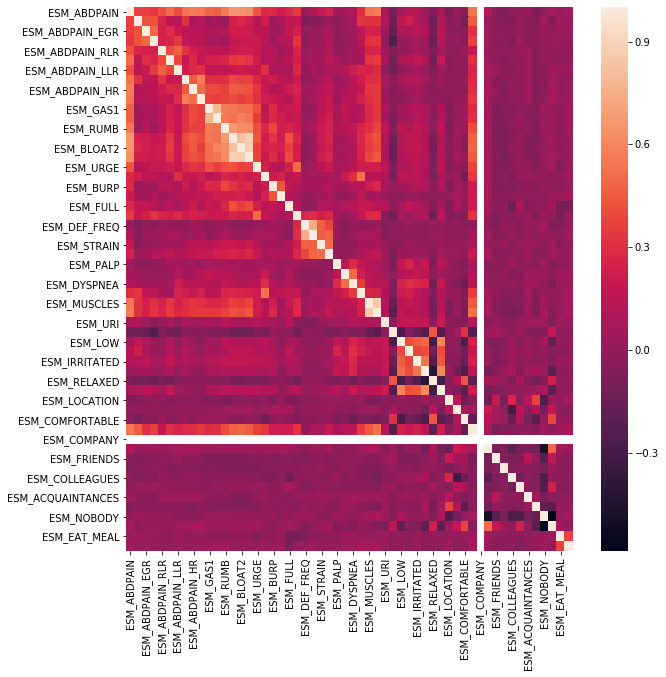

In [18]:
# esm_no_date_pd.drop("ESM_ABDPAIN",axis=1) (if we want to erase the features correlated between eachother we should dorp the target)
corr = esm_no_date_pd.corr()
sns.heatmap(corr)
columns = np.full((corr.shape[0],), True, dtype=bool)

In [19]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
                          
selected_columns_corr = esm_no_date_pd.columns[columns==False]

In [20]:
selected_columns_corr

Index(['ESM_BLOAT2', 'ESM_BLOAT3', 'ESM_JOINTS'], dtype='object')

# Lasso

Best alpha using built-in LassoCV: 0.015200
Best score using built-in LassoCV: 0.753227
Lasso picked 43 variables and eliminated the other 12 variables


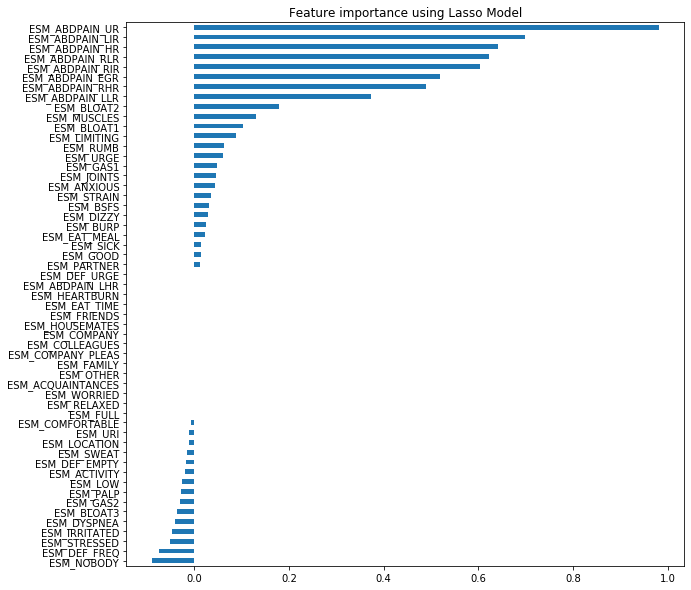

In [21]:
from sklearn.linear_model import LassoCV
X = esm_no_date_pd.drop("ESM_ABDPAIN",axis=1)
y = esm_no_date_pd["ESM_ABDPAIN"]

reg = LassoCV()
reg.fit(X,y)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model");

X_columns = [col for col in X.columns]
selected_features_lasso= []
for i in range(0, coef.shape[0]):
    if coef[i] !=0:
        selected_features_lasso.append(X_columns[i])

# Mutual information

In [22]:
from sklearn.feature_selection import mutual_info_classif
m_i =mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
        

In [23]:
selected_features_mutualinfo= []
for i in range(0, m_i.shape[0]):
    if m_i[i] >= 0.1:
        selected_features_mutualinfo.append(X_columns[i])

In [24]:
selected_features_mutualinfo

['ESM_ABDPAIN_UR',
 'ESM_ABDPAIN_RIR',
 'ESM_ABDPAIN_HR',
 'ESM_ABDPAIN_LIR',
 'ESM_GAS1',
 'ESM_GAS2',
 'ESM_RUMB',
 'ESM_BLOAT1',
 'ESM_BLOAT2',
 'ESM_BLOAT3',
 'ESM_URGE',
 'ESM_MUSCLES',
 'ESM_JOINTS',
 'ESM_LIMITING']

# Multivariate filters